### Visualize motifs in PCA and tSNE space

In [3]:
import os
import re
import glob
import numpy as np
import pandas as pd
import itertools
import plotly.express as px
# from sklearn.manifold import TSNE
from cuml.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

In [4]:
def encoding(df, bases_list):
    data = np.stack(df.loc[:, 'Sequence'].astype('str').apply(list).values, axis=0)
    e = LabelEncoder()
    e.fit(bases_list)
    encoded = e.transform(data.reshape(-1)).reshape(-1, len(data[0]))
    return encoded

In [5]:
def pca_pep(df, encoded, n=2):
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(encoded)
    row, col = principalComponents.shape
    for i in range(col):
        df['pca_{}'.format(i+1)] = principalComponents[:, i]
    return principalComponents, df

In [6]:
def t_sne_pep(df, encoded, n=2):
    t_sne = TSNE(n_components=n, verbose=1, perplexity=50, n_iter=5000, learning_rate=200)
    t_distributed = t_sne.fit_transform(encoded)
    row, col = t_distributed.shape
    for i in range(col):
        df['t_SNE_{}'.format(i+1)] = t_distributed[:, i]
    return t_distributed, df

In [7]:
def get_motif_index(dictionary,sequence):

    index_pos = dictionary[sequence][0].strip('[]').split(',')
    index_neg = dictionary[sequence][1].strip('[]').split(',')
    index_pos = [int(x) for x in index_pos]
    index_neg = [int(x) for x in index_neg]

    return index_pos,index_neg       

In [8]:
def change_class(df,index_list,n):
    df_n = df.copy(deep=True)
    for index in index_list:
        df_n.loc[index,'Class'] = n
    return df_n

In [9]:
def get_motif_df(df_pos,index_pos,n1,df_neg,index_neg,n2):
    df_sub1 = extract_subdf(df_pos,index_pos,n1)
    df_sub2 = extract_subdf(df_neg,index_neg,n2)
    df_sub = pd.concat([df_sub1,df_sub2])
    df_sub.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
    return df_sub

In [10]:
def mark_origial_seq(df,orig_seq,class_n,normal_size,mark_size):
    df['marker_size'] = 10
    for i in range(len(df)):
        if df.at[i,'Sequence'] == orig_seq:
            df.at[i,'Class'] = class_n           
            df.at[i,'marker_size'] = 20
    return df

## Get the PCA and T_SNE vectors of the whole dataset

In [54]:
'''change file names, motif and base_list here. Choose ['A','T','G','C'] for DNA data'''
pos_seqs = 'pos_seqs.csv'
neg_seqs = 'neg_seqs.csv'
motif_file = 'keating_length 11.csv'
motif = 'L*RIGDE*DAY'
#bases_list = ['A','T','G','C']
bases_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
                 'S', 'T', 'V', 'W', 'Y']

In [55]:
df_pos = pd.read_csv(pos_seqs)
df_neg = pd.read_csv(neg_seqs)
df_pos['Class'] = 'positive_seq'
df_neg['Class'] = 'negative_seq'

df = pd.concat([df_pos,df_neg])
df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

encoded = encoding(df, bases_list)
principalComponents, df_pca = pca_pep(df, encoded, n=2)
t_distributed, df_sne =  t_sne_pep(df_pca, encoded, n=2)
df_top_500 = pd.concat([df_sne.head(500),df_sne.tail(500)])
df_sne.rename(columns = {'pca_1':'PC 1', 'pca_2':'PC 2'}, inplace = True)

/home/huanhuan/miniconda3/envs/rapids-22.04/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


In [61]:
len(df_pos)

3480

## Choose a motif and get the index of it's occurrence in sequences, change the Class of these sequences

In [56]:
df_motif = pd.read_csv(motif_file)
dict_motif = dict([(i,[a,b]) for i, a,b in zip(df_motif.motifs, df_motif.index_pos,df_motif.index_neg)])
index_pos,index_neg = get_motif_index(dict_motif,motif)
df_v1 = change_class(df_sne,index_pos,'pos_motif')
index_neg_n = [x + len(df_pos) for x in index_neg]
df_v2 = change_class(df_v1,index_neg_n,'neg_motif')
df_v3 = df_v2.loc[df_v2['Class'].isin(['pos_motif','neg_motif'])]   

In [57]:
encoded_sub = encoding(df_v3, bases_list)
principalComponents, df_pca_sub = pca_pep(df_v3[['Sequence','Class']], encoded_sub, n=2)
t_distributed, df_sne_sub =  t_sne_pep(df_pca_sub, encoded_sub, n=2)
df_sne_sub.rename(columns = {'pca_1':'PC 1', 'pca_2':'PC 2'}, inplace = True)

/tmp/ipykernel_11800/3260425373.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pca_{}'.format(i+1)] = principalComponents[:, i]
/home/huanhuan/miniconda3/envs/rapids-22.04/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


In [58]:
def save_fig(*args):
    
    plt.rcParams.update({'font.size': 45})
    mpl.rcParams['font.family'] = 'Arial'
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes((0.1,0.1,0.5,0.8))
    ax.spines['right'].set_visible(True)
    ax.spines['right'].set_linewidth(4)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_visible(True)
    ax.spines['top'].set_linewidth(4)
    ax.tick_params(axis='both',which='major',direction='out',length=10,width=5,color='black',pad=15,labelsize=30,
                   labelcolor='black',
                   labelrotation=0)

    ax.set_xlabel('\n' + args[0])
    ax.set_ylabel(args[1] + '\n')

    if len(args) == 7:
        
        labels_dict = {'positive_seq': '#69BFA0','negative_seq': '#FF7F00', 'pos_motif': '#0000FF',
                       'neg_motif':'#FF0000'}
    
        ax.scatter(args[-1][args[0]], args[-1][args[1]],
                   edgecolor='none', alpha=0.5,
                   c=args[-1][args[2]].map(labels_dict), s= 50)
    else: 
        
        labels_dict = { 'pos_motif': '#0000FF', 'neg_motif':'#FF0000'}
        
    ax.scatter(args[5][args[0]], args[5][args[1]],
               edgecolor='none', alpha=0.8,
               c=args[5][args[2]].map(labels_dict), s= 50)


    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=20, 
                      markeredgecolor = 'none') for k, v in
               labels_dict.items()]

    ax.legend(title=args[2], handles=handles, bbox_to_anchor=(1.7, 1), loc='upper right', frameon=False, 
              prop={'size': 35},title_fontsize=35)

    # fig.suptitle(title, )
    title = args[3]
    plt.title(title,x=0.5, y=1.02,fontsize= 35)
    #ax.set_title(args[3])
    ax.set_xlabel( args[0],fontsize= 35)
    ax.set_ylabel(args[1], fontsize= 35)
    plt.savefig(args[4], bbox_inches='tight')
    plt.figure().clear()
    plt.show()
    plt.cla()
    plt.clf()

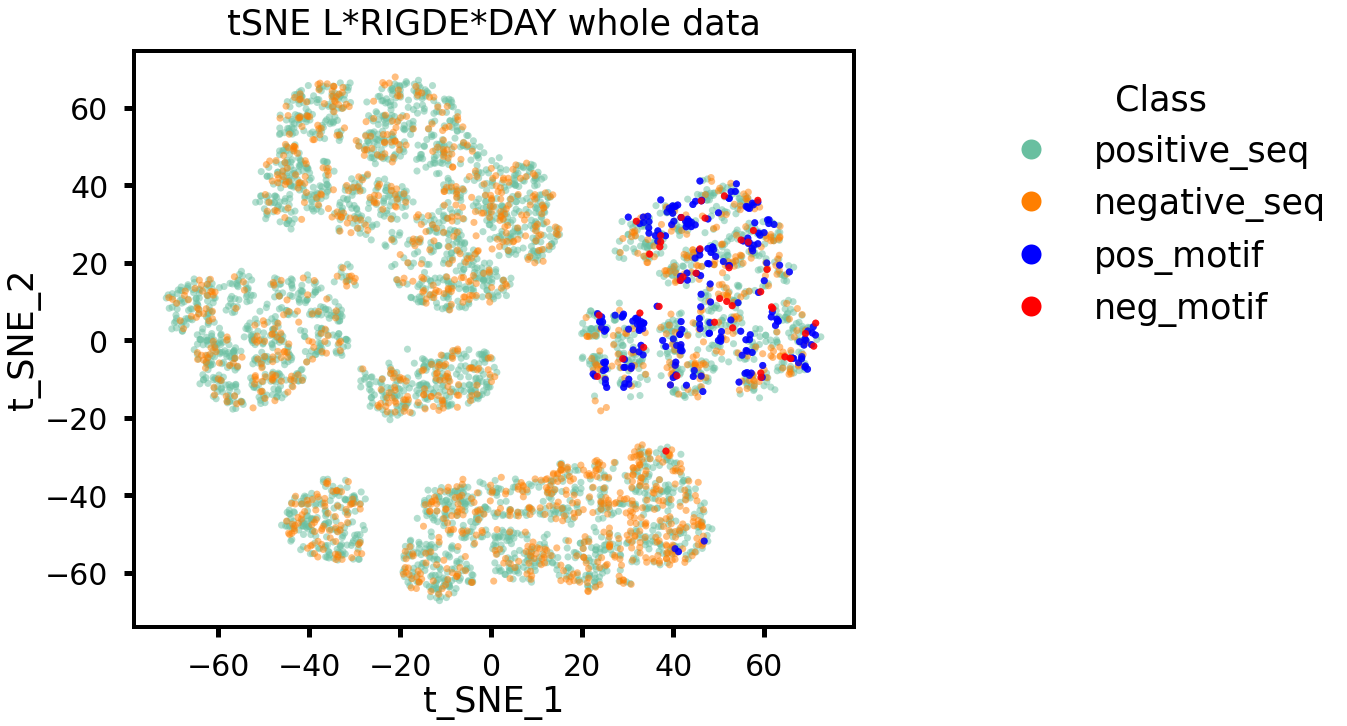

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

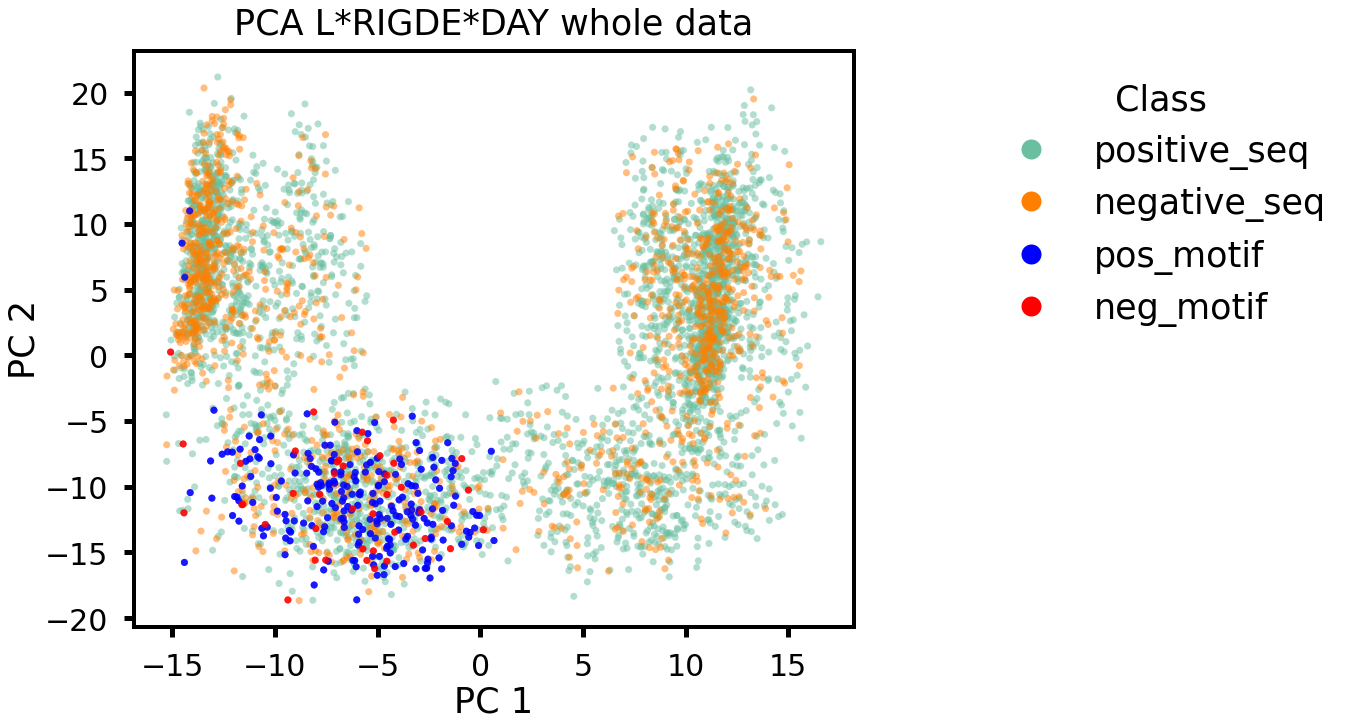

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [59]:
args1 = ['t_SNE_1', 't_SNE_2', 'Class', 'tSNE {} whole data'.format(motif), 'tSNE {} whole data'.format(motif), df_v3,df_v2]
args2 = ['PC 1', 'PC 2', 'Class', 'PCA {} whole data'.format(motif), 'PCA {} whole data'.format(motif), df_v3,df_v2]
save_fig(*args1)
save_fig(*args2)

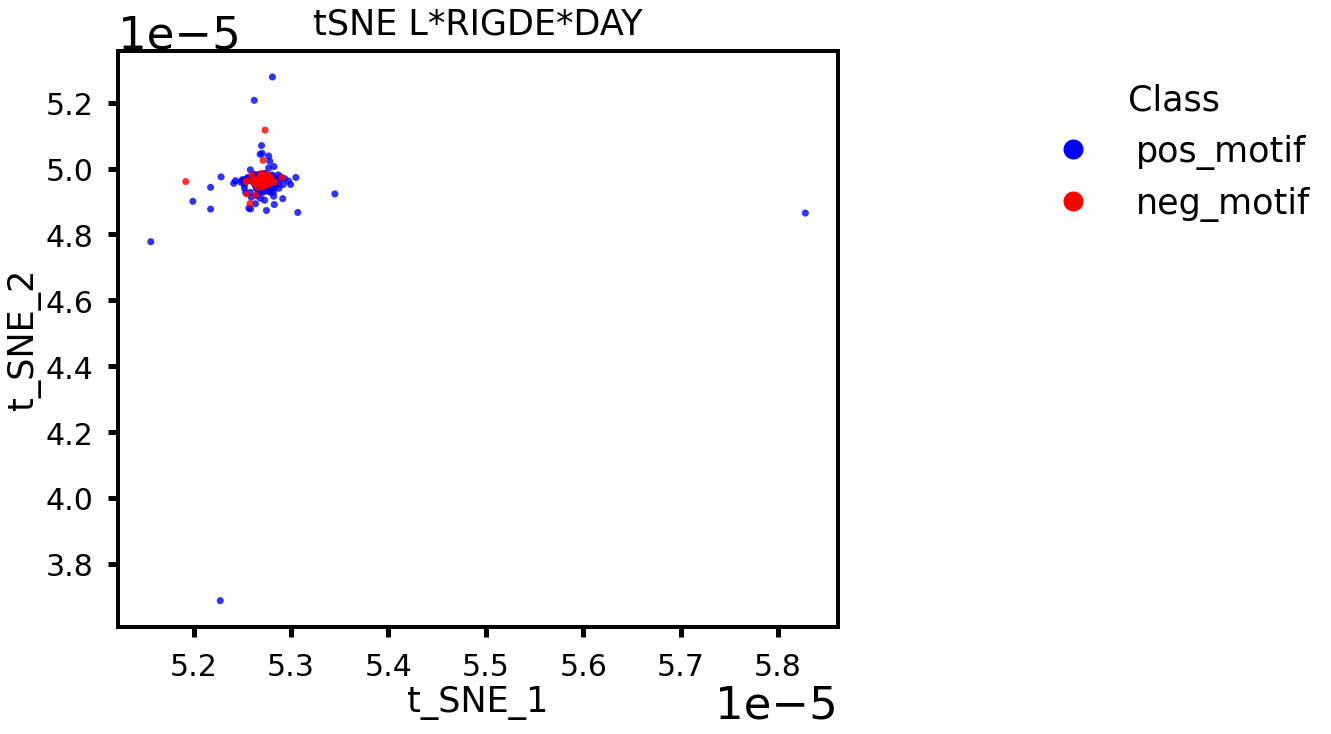

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

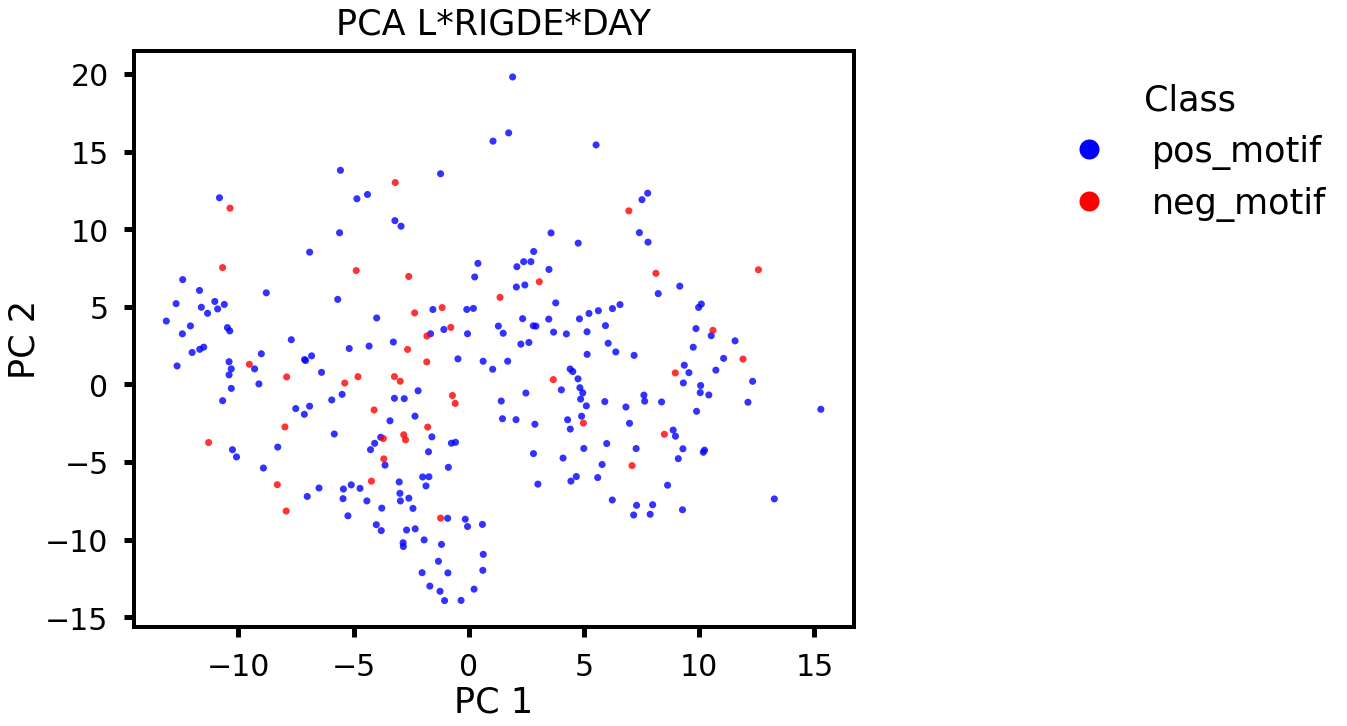

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [60]:
args3 = ['t_SNE_1', 't_SNE_2', 'Class', 'tSNE {}'.format(motif), 'tSNE {}'.format(motif), df_sne_sub]
args4 = ['PC 1', 'PC 2', 'Class', 'PCA {}'.format(motif), 'PCA {}'.format(motif), df_sne_sub]
save_fig(*args3)
save_fig(*args4)